In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"
}

In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/Screen1_66guides_Lib_1.h5seurat"
seurat_all  <- LoadH5Seurat(h5_path, verbose = FALSE)

Validating h5Seurat file



Use only singlets

In [6]:
seurat <- subset(seurat_all, subset = status == 'singlet')

# Call guides using the Poisson-Gaussian Mixture Model

In [7]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [8]:
head(df_guide_counts)

,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b,n_guides
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,57,0,⋯,0,0,0,1,0,1,0,0,0,92
2,0,0,0,0,0,0,1,0,1302,1753,⋯,1,0,1,1,0,0,1,2,0,3081
3,0,0,0,0,0,0,0,0,428,1565,⋯,0,0,0,1,0,0,0,0,0,2006
4,0,0,0,0,0,0,0,0,1515,3322,⋯,0,0,0,0,0,0,1,1,0,4873
5,0,0,0,0,0,0,0,0,343,433,⋯,0,0,0,0,0,1,0,0,0,783
6,1,1,0,2,1,1,2,0,1943,2353,⋯,1,2,1,1,1,1,1,2,0,4468


In [9]:
y = df_guide_counts[,'CD13-1a']
select_nonzeros = y > 0
y = y[select_nonzeros]
log_y = log(y, 2)

In [10]:
calls <- pgmix(y)

In [11]:
df_calls = as.data.frame(calls)
df_calls['counts'] = y
colnames(df_calls) = c('call', 'prob', 'count')

In [12]:
dim(df_calls)
length(y)
head(df_calls)

[1] 1311    3

[1] 1311

,call,prob,count
,<dbl>,<dbl>,<dbl>
1,1,1.6e-08,1
2,1,2.4e-06,2
3,1,1.6e-08,1
4,1,1.6e-08,1
5,1,1.6e-08,1
6,1,2.4e-06,2


,call,prob,count
,<dbl>,<dbl>,<dbl>
1,1,1.6e-08,1
2,1,2.4e-06,2
3,1,1.6e-08,1
4,1,1.6e-08,1
5,1,1.6e-08,1
6,1,2.4e-06,2


[1] 1311    3

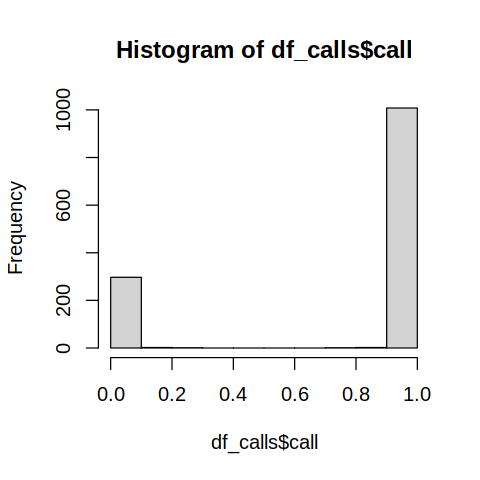

[1] 300   3

threshold= 13

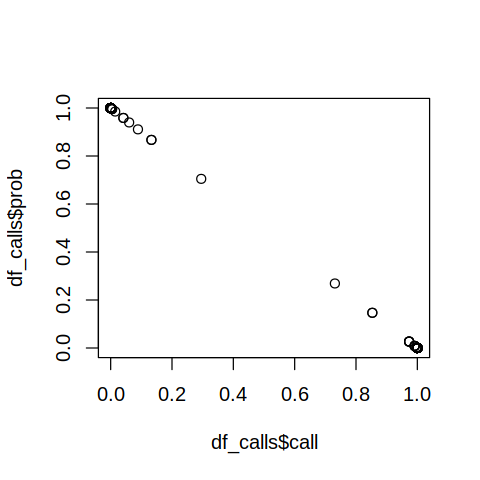

In [13]:
options(repr.plot.width=4, repr.plot.height=4)
CUTOFF_PROB = 0.5
head(df_calls)
dim(df_calls)
select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
hist(df_calls$call)
plot(df_calls$call, df_calls$prob)

df_gauss = df_calls[select_gaussian_assigned,]
dim(df_gauss)
 
# head(df_gauss)
threshold = min(df_gauss$count)
cat("threshold=", threshold)

In [14]:
filter_y = y > 2
y_filtered = y[filter_y]
df_y = as.data.frame(y_filtered)
head(df_y)

,y_filtered
,<dbl>
1,4
2,16
3,3
4,3
5,9
6,3


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


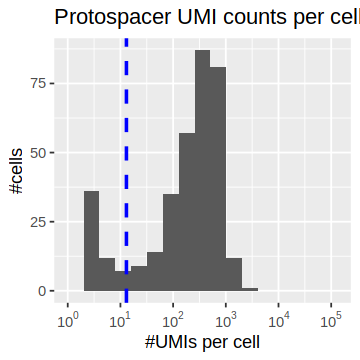

In [15]:
options(repr.plot.width=3, repr.plot.height=3)
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +  geom_vline(aes(xintercept=threshold), color="blue", linetype="dashed", size=1)

ggp1

# Call all guides

In [16]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [17]:
head(df_guide_counts)

,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b,n_guides
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,57,0,⋯,0,0,0,1,0,1,0,0,0,92
2,0,0,0,0,0,0,1,0,1302,1753,⋯,1,0,1,1,0,0,1,2,0,3081
3,0,0,0,0,0,0,0,0,428,1565,⋯,0,0,0,1,0,0,0,0,0,2006
4,0,0,0,0,0,0,0,0,1515,3322,⋯,0,0,0,0,0,0,1,1,0,4873
5,0,0,0,0,0,0,0,0,343,433,⋯,0,0,0,0,0,1,0,0,0,783
6,1,1,0,2,1,1,2,0,1943,2353,⋯,1,2,1,1,1,1,1,2,0,4468


In [18]:
CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)
# Remove the last column from the list
guides = guides[guides != "n_guides"]
plots = list()
thresholds = list()
valid_guides = list()

for(i in seq_along(guides)) {
    guide = guides[[i]]
    y = df_guide_counts[,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    if(length(y) == 0) {
        cat("Skipping", guide, "\n")
        next
    }

    calls <- pgmix(y)
    df_calls = as.data.frame(calls)
    df_calls['counts'] = y
    colnames(df_calls) = c('call', 'prob', 'count')
    options(repr.plot.width=4, repr.plot.height=4)
    head(df_calls)
    dim(df_calls)
    select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
    # hist(df_calls$call)
    #plot(df_calls$call, df_calls$prob)

    df_gauss = df_calls[select_gaussian_assigned,]
    dim(df_gauss)
    
    # head(df_gauss)
    threshold = min(df_gauss$count)
    #cat("threshold=", threshold)
    filter_y = y > 0
    y_filtered = y[filter_y]
    df_y = as.data.frame(y_filtered)
    head(df_y)
    
    options(repr.plot.width=3.3, repr.plot.height=2.4)
    bin_breaks <- c(1,2,2*2^(1:16))
    title = paste0(guide, ", T=", threshold)

    ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
    geom_histogram(breaks=bin_breaks) + 
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
        labs(title=title, x=NULL, y=NULL) +  
        geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
        theme(plot.title = element_text(size=10))

    #plots[[i]] <- ggp1
    #print(ggp1)
    plots <- append(plots, list(ggp1))
    #thresholds <- c(thresholds, list(list(library, guide, threshold)))
    thresholds <- c(thresholds, threshold)
    valid_guides <- c(valid_guides, guide)
}

Skipping FTH1-2b 
Skipping DE2-1a 
Skipping DE2-1b 
Skipping DE9-2a 
Skipping DE9-2b 
Skipping DE16-2a 
Skipping NTCE1-1b 
Skipping NTCE2-1a 
Skipping NTCE2-1b 


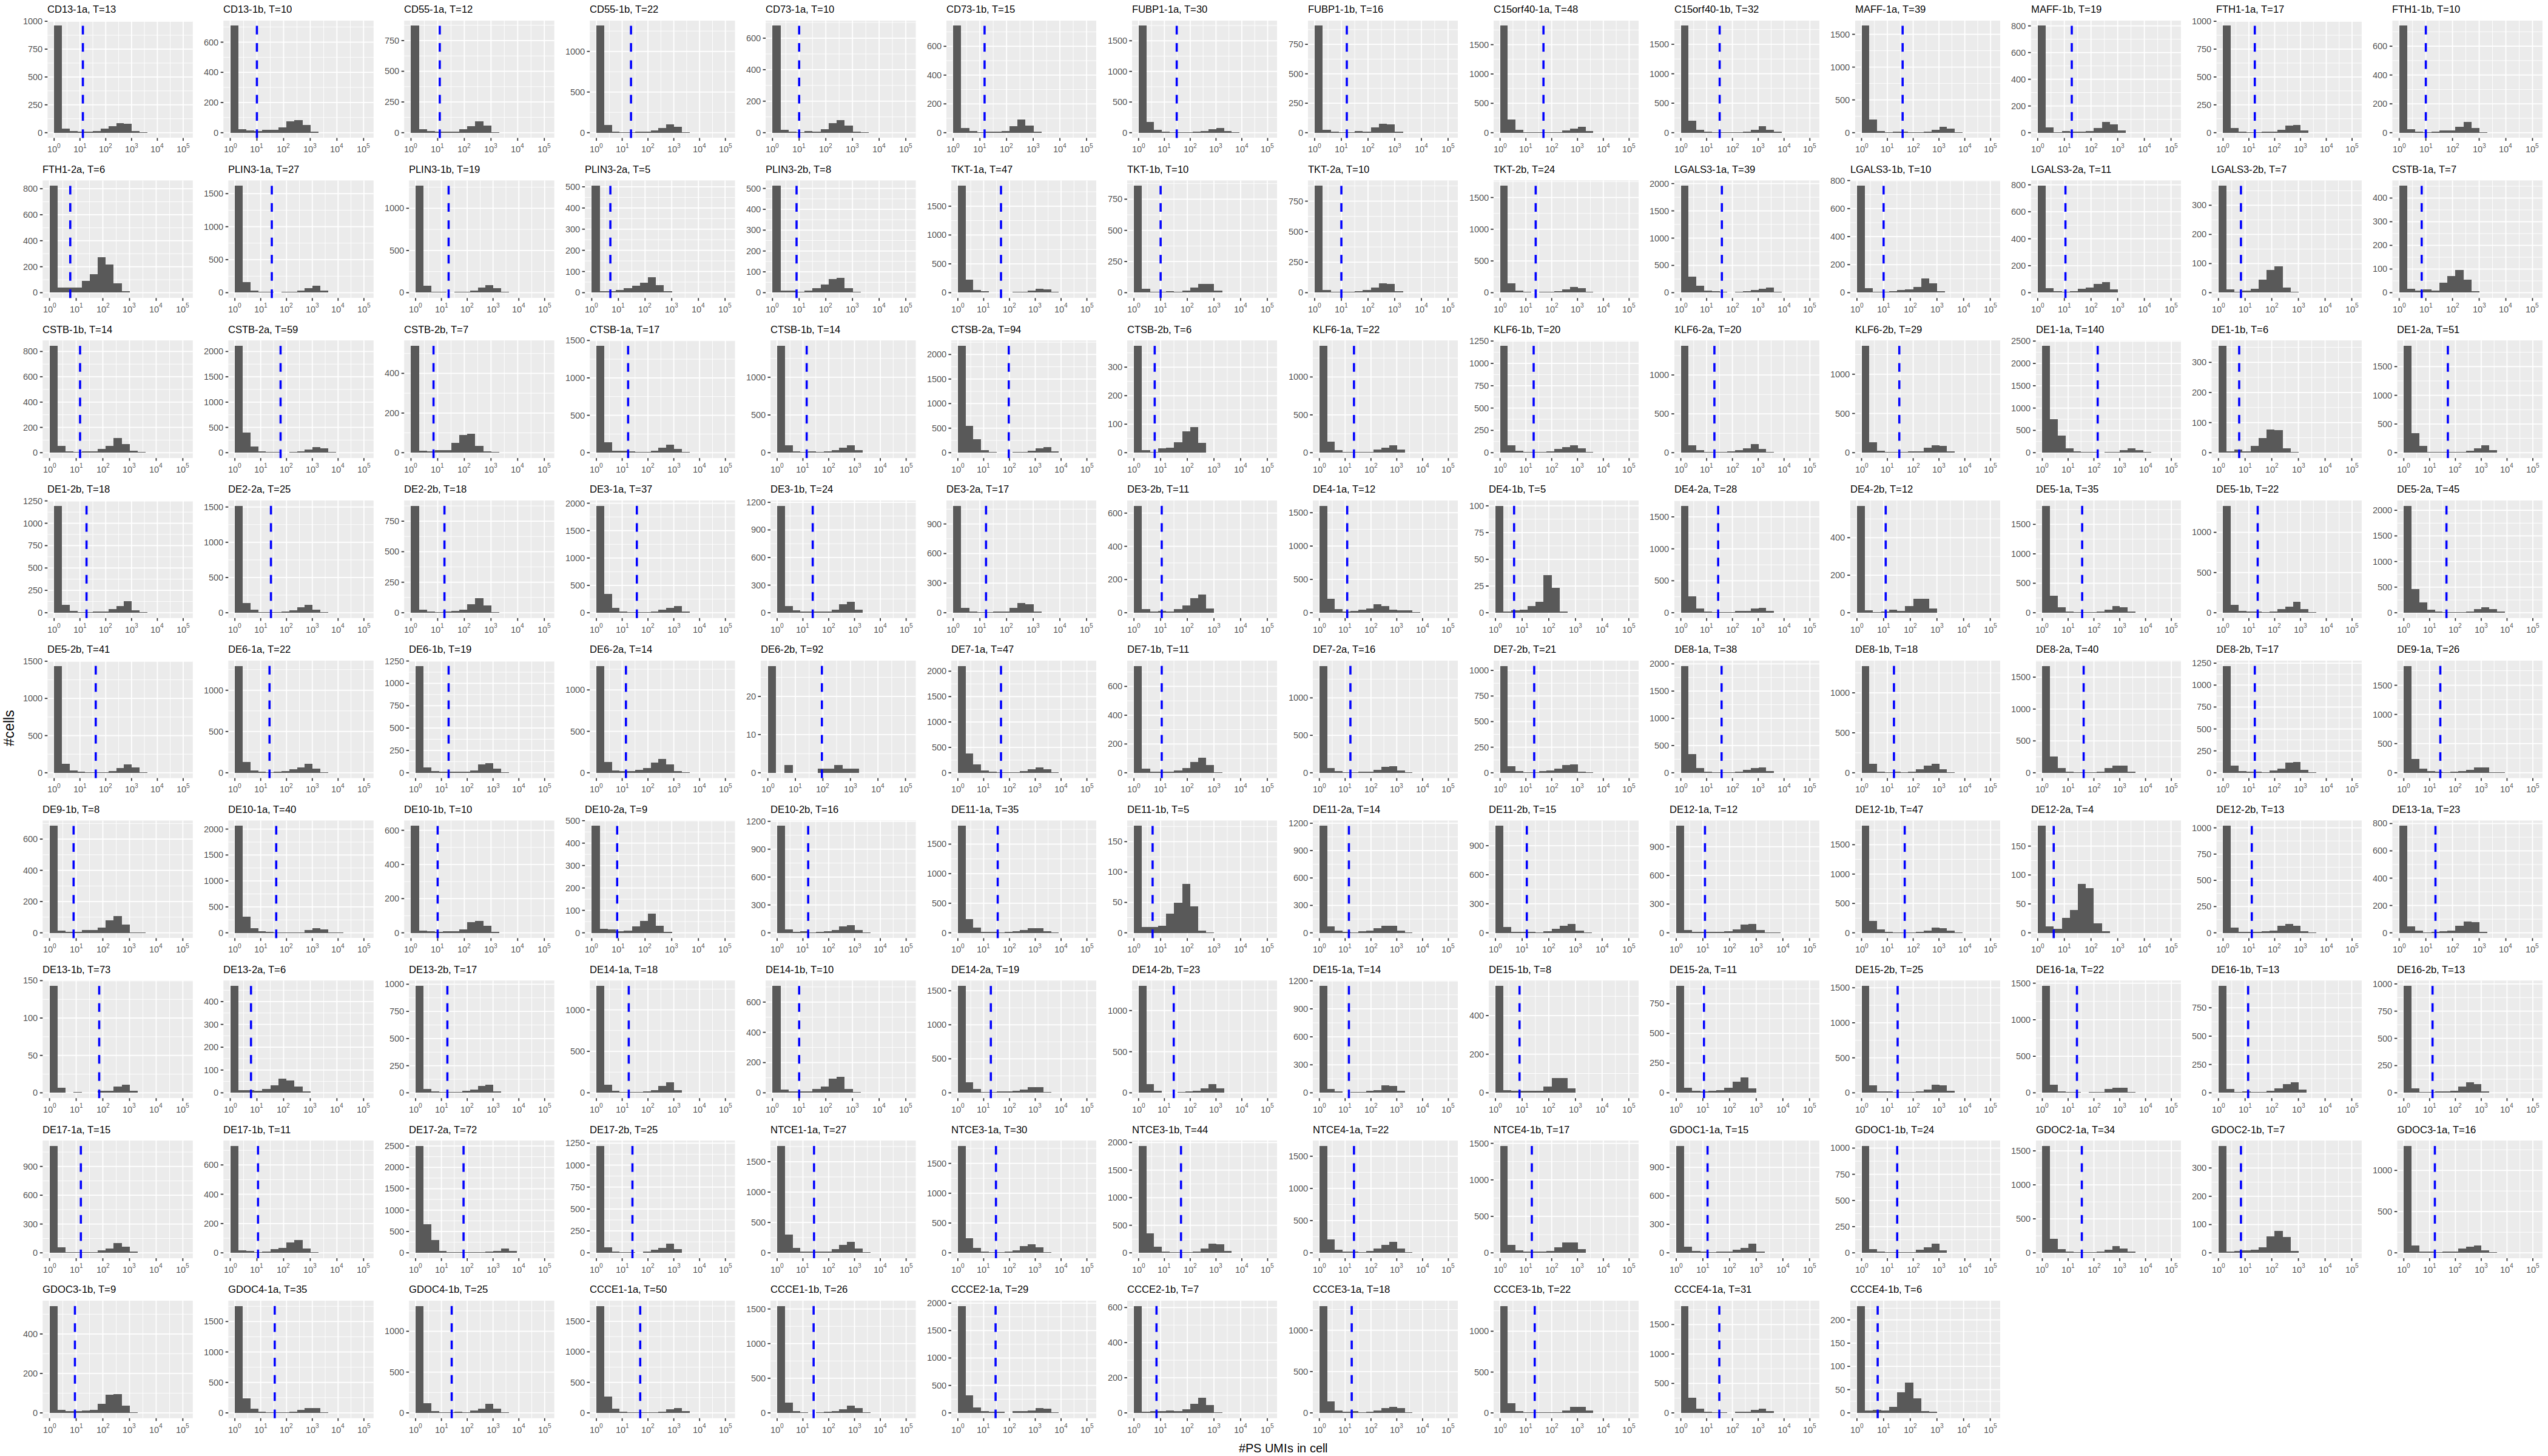

In [19]:
options(repr.plot.width=35, repr.plot.height=20)
#do.call(grid.arrange, plots[1:2])
gridExtra::grid.arrange(
    grobs = plots, 
    ncol = 14, 
    bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
    left=textGrob("#cells", gp=gpar(fontsize=14), rot=90)
    )
#print(ggarrange(plots[[1]], plots[[2]], plots[[3]], ncol = 3))

# Write thresholds to file

In [20]:
valid_guides = matrix(unlist(valid_guides))
thresholds = matrix(unlist(thresholds))
df_thresholds = data.frame(guide=valid_guides, threshold=thresholds)
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")

head(df_thresholds)
write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)

,guide,threshold
,<chr>,<dbl>
1,CD13-1a,13
2,CD13-1b,10
3,CD55-1a,12
4,CD55-1b,22
5,CD73-1a,10
6,CD73-1b,15


In [21]:
thr_f_name

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//integrated/THRESHOLDS.tsv"

# Debug

In [22]:
head(seurat)

,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,orig.ident,nCount_sgRNA,nFeature_sgRNA,library,percent.mt,PS_call,construct_call,target_call,nCalled_Constructs,nPS_calls,nCalled_sgRNA_UMIs,status,donor
,<dbl>,<int>,<dbl>,<int>,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,<chr>,<chr>,<chr>
AGCTCAATCGTAGGGA-1,32644,5712,39417,5687,Screen1_66guides,92,9,Lib_1,4.8,C15orf40_1a,C15orf40_1,C15orf40,1,1,57,singlet,3
AAACGCTCAGTTAGAA-1,44827,7247,41368,7172,Screen1_66guides,3081,27,Lib_1,9.7,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1302|1753,singlet,0
AAAGGATAGCGATTCT-1,50419,7705,41469,7625,Screen1_66guides,2006,14,Lib_1,9.5,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,428|1565,singlet,0
ATCGGCGGTCTAGATC-1,40213,6389,40246,6343,Screen1_66guides,4873,32,Lib_1,6.9,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1515|3322,singlet,2
CAAGAGGCAGTTCTAG-1,32899,5995,39391,5963,Screen1_66guides,783,9,Lib_1,5.6,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,343|433,singlet,1
CCTGCATTCAAGCCAT-1,39516,7020,39922,6962,Screen1_66guides,4468,87,Lib_1,12.0,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1943|2353,singlet,1
GTAATCGCACATACGT-1,72098,9371,41427,8452,Screen1_66guides,2916,23,Lib_1,7.1,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,1337|1554,singlet,1
GTACAACGTGTGATGG-1,45773,7442,41464,7377,Screen1_66guides,6414,30,Lib_1,12.5,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,3233|3145,singlet,2
GTAGAGGGTCTTTCAT-1,26468,5122,39538,5171,Screen1_66guides,1849,61,Lib_1,6.4,C15orf40_1a|C15orf40_1b,C15orf40_1,C15orf40,1,2,716|1029,singlet,2
